# Sample Synthesis

Uses ATR spectra from various materials to sythesis sample spectra in order to simulate spectroscopy binary classification proiblems. <br> This is a work in progress.

Author: Zheng Tang <br>
Baseline correction algorithm: Edward Duckworth <br>
Collab: Dr. Deb Roy, Dr. Ben Mora

In [55]:
# Usuals
import pandas as pd
import numpy as np
import random
from numpy import arange
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import platform
import sys
import sklearn as sk
import math
import os
import glob
import itertools
import datetime
from tqdm import tqdm
import time
import pickle

# Statistics
from scipy import stats

# PCA
from sklearn import decomposition

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize

# LOOCV
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold, StratifiedGroupKFold

# Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

# SVM
import itertools
from sklearn import svm

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from Utilities import generate_alss, import_group_spectra
from scipy.interpolate import griddata

### Processing original spectra

In [56]:
df_path = './ATR Spectra/'

Select from ATR spectra by visually inspect groups of samples, those with similar characteristics are groups into one. 

In [57]:
all_groups, all_group_names = import_group_spectra(df_path)

Finished Globbing 174 files
Processing ./ATR Spectra\1_2_polybutadiene.csv
Processing ./ATR Spectra\acrylonitrile_butadiene.csv
Processing ./ATR Spectra\acrylonitrile_butadiene_styrene.csv
Processing ./ATR Spectra\algae laminaria sacharina.csv
['./ATR', 'Spectra\\algae', 'laminaria', 'sacharina.csv']  added to df_algae
Processing ./ATR Spectra\algae_desmarestia_viridis.csv
['./ATR', 'Spectra\\algae_desmarestia_viridis.csv']  added to df_algae
Processing ./ATR Spectra\algae_fucus_serratus.csv
['./ATR', 'Spectra\\algae_fucus_serratus.csv']  added to df_algae
Processing ./ATR Spectra\algae_laminaria_digita_and_hyperborea.csv
['./ATR', 'Spectra\\algae_laminaria_digita_and_hyperborea.csv']  added to df_algae
Processing ./ATR Spectra\alginic_acid_ sodium_salt.csv
Processing ./ATR Spectra\alkyd_varnish.csv


Processing ./ATR Spectra\amber.csv
['./ATR', 'Spectra\\amber.csv']  added to df_amber
Processing ./ATR Spectra\aramid.csv
['./ATR', 'Spectra\\aramid.csv']  added to df_aramid
Processing ./ATR Spectra\black_broodcomb.csv
['./ATR', 'Spectra\\black_broodcomb.csv']  added to df_broodcomb
Processing ./ATR Spectra\broodcomb.csv
['./ATR', 'Spectra\\broodcomb.csv']  added to df_broodcomb
Processing ./ATR Spectra\broodcomb_once_brooded.csv
['./ATR', 'Spectra\\broodcomb_once_brooded.csv']  added to df_broodcomb
Processing ./ATR Spectra\butyl_methacrylate_isobutyl_methacrolate.csv
Processing ./ATR Spectra\cellulose.csv
Processing ./ATR Spectra\cellulose_acetate.csv
Processing ./ATR Spectra\cellulose_acetate_butyrate.csv
Processing ./ATR Spectra\cellulose_propionate.csv
Processing ./ATR Spectra\cellulose_wipe.csv
Processing ./ATR Spectra\chitin_cancer_pagurus.csv
['./ATR', 'Spectra\\chitin_cancer_pagurus.csv']  added to df_chitin
Processing ./ATR Spectra\chitin_crangon_antonia.csv
['./ATR', 'Spect

### Synthesising df

In [58]:
# Print names of each group imported
print('Groups are: ', all_group_names)

Groups are:  ['nylon', 'cotton', 'wool', 'silicone', 'vinyl_alcohol', 'algae', 'honeycomb', 'chitin', 'fur', 'polyester', 'grass', 'coal', 'silk', 'viscose', 'amber', 'aramid', 'down', 'broodcomb', 'flax', 'cigarette_filter']


In [59]:
def normalization(spectrum):
    # Normalizing to unit vector for simplicity
    norm = np.linalg.norm(spectrum)
    if norm == 0: 
       return spectrum
    return spectrum / norm

def minmax_scale_spectrum(df, new_min=0, new_max=1):

    # Calculate min and max of the df
    old_min = np.min(df)
    old_max = np.max(df)

    # Prevent division by zero in case all values in df are the same
    if old_min == old_max:
        return np.full(df.shape, new_min) if old_min <= new_min else np.full(df.shape, new_max)

    # Scaling
    scaled_df = (new_max - new_min) * (df - old_min) / (old_max - old_min) + new_min

    return scaled_df


normalize = True
all_groups_normalized = []
for group in all_groups:
    group = normalization(group)
    all_groups_normalized.append(group)

if normalize:
    all_groups = all_groups_normalized


minmax = True
all_groups_minmax = []
for group in all_groups:
    group = minmax_scale_spectrum(group)
    all_groups_minmax.append(group)

if minmax:
    all_groups = all_groups_minmax

In [60]:
# Determine desired number of groups of spectra to synthesize sampels
num_groups = 15

# Number of samples
num_samples = 100

# If to output to CSv
output_to_file = False

### Add noise (optional)

In [61]:
def add_noise(samples_c1, samples_c2, mu, sigma):
       
       # creating a noise with the same dimension as the dfset (2,2) 
       noise_1 = np.random.normal(mu, sigma, [num_samples,1863]) 
       # noise_2 = np.random.normal(mu, sigma, [num_samples,1863]) 

       return samples_c1 + noise_1, samples_c2 + noise_1

#### Plot average spectrum

In [62]:
def plot_class_spectrum(samples_c1, samples_c2):
    spectra_c1 = samples_c1.iloc[:,:-1]
    spectra_c2 = samples_c2.iloc[:,:-1]

    X = np.arange(750, 2612, 1)
    y1 = spectra_c1.mean(axis=0)
    y2 = spectra_c2.mean(axis=0)

    plt.plot(X, y1, color='tab:red', label='Class 1') 
    plt.plot(X, y2, color='tab:blue', label='Class 2')

    plt.xlabel("Wavenumbers($cm^{-1}$)") 
    plt.ylabel("Intensity") 
    # plt.title("") 

    plt.legend() 
    plt.show() 

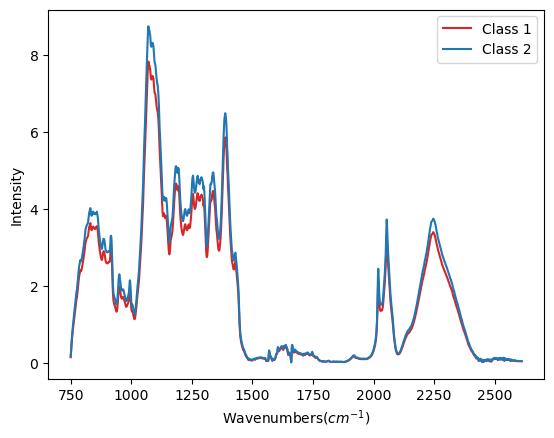

In [63]:
# Groups: selected groups of spectra to synthesize samples from (dictated by num_groups)
def synthesize_sample(groups, mean, std_dev):
    weights = np.random.normal(mean, std_dev, len(groups))
    sample = sum(weight * spectrum for weight, spectrum in zip(weights, groups))
    return sample

def generate_samples(all_groups, mean_c1, sig_c1, mean_c2, sig_c2, plot_avg=False):
    synthesized_df = pd.DataFrame([synthesize_sample(all_groups, mean_c1, sig_c1) if i < num_samples # first half of the samples are class 1
                                 else synthesize_sample(all_groups, mean_c2, sig_c2) # the rest are class 2
                                 for i in range(num_samples*2)])
    synthesized_df['Label'] = [0] * num_samples + [1] * num_samples

    if plot_avg:
        plot_class_spectrum(synthesized_df[synthesized_df['Label'] == 0].drop(columns='Label'), 
                            synthesized_df[synthesized_df['Label'] == 1].drop(columns='Label'))

    return synthesized_df

# Similar to Filtered blood distribution (3:2)
def generate_samples_unbalanced(all_groups, mean_c1, sig_c1, mean_c2, sig_c2, plot_avg=False):
    synthesized_df = pd.DataFrame([synthesize_sample(all_groups, mean_c1, sig_c1) if i < int(num_samples*1.5) # first 2/3 of the samples are class 1
                                 else synthesize_sample(all_groups, mean_c2, sig_c2) # the rest are class 2
                                 for i in range(int(num_samples*2.5))])
    synthesized_df['Label'] = [0] * int(num_samples*1.5) + [1] * num_samples

    if plot_avg:
        plot_class_spectrum(synthesized_df[synthesized_df['Label'] == 0].drop(columns='Label'), 
                            synthesized_df[synthesized_df['Label'] == 1].drop(columns='Label'))

    return synthesized_df

example_data = generate_samples(all_groups[:num_groups], mean_c1=1, sig_c1=0.25, mean_c2=1.12, sig_c2=0.25, plot_avg=True)

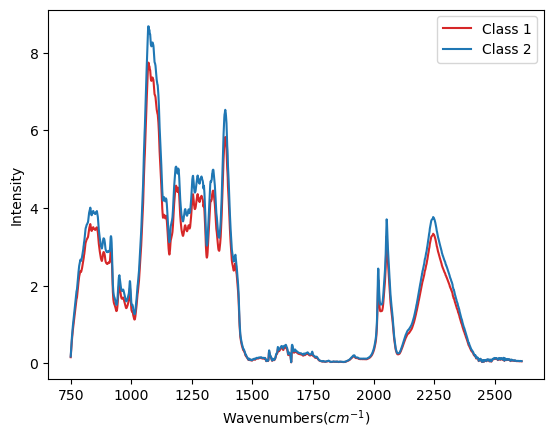

In [64]:
example_data_unbalanced = generate_samples_unbalanced(all_groups[:num_groups], mean_c1=1, sig_c1=0.25, mean_c2=1.12, sig_c2=0.25, plot_avg=True)

Percentage of variance explained:  0.9999999999999998


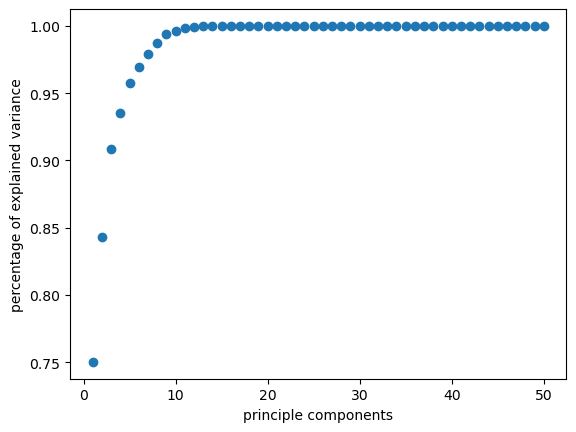

In [65]:
def pca(X_train, X_test, num_components, verbose=1, plot=0):

    pca = decomposition.PCA(n_components = num_components, random_state=1)
    pca.fit(X_train)

    X_train_redu = pd.DataFrame(data = pca.transform(X_train))
    if X_test.empty==False:
        X_test_redu = pd.DataFrame(data = pca.transform(X_test))
    else:
        X_test_redu = pd.DataFrame()

    if verbose:
        print('Percentage of variance explained: ', sum(pca.explained_variance_ratio_[:num_components]))
    
    return X_train_redu, X_test_redu

def pca_separated(X_train, X_test, y_train, num_components, verbose=1, plot=0):
    if verbose:
        print('Performing PCA on each class separately')

    recomb = pd.concat([X_train, y_train],axis=1) 
    X_train_c0 = recomb[recomb['Label']==0].drop(columns=['Label'])
    X_train_c1 = recomb[recomb['Label']==1].drop(columns=['Label'])

    pca_c0 = decomposition.PCA(n_components = int(num_components), random_state=1)
    pca_c1 = decomposition.PCA(n_components = int(num_components), random_state=1)
    pca_c0.fit(X_train_c0)
    pca_c1.fit(X_train_c1)

    X_train_redu_c0 = pd.DataFrame(data = pca_c0.transform(X_train))
    X_train_redu_c1 = pd.DataFrame(data = pca_c1.transform(X_train))
    X_train_redu = pd.concat([X_train_redu_c0, X_train_redu_c1],axis=1)

    if X_test.empty==False:
        X_test_redu_c0 = pd.DataFrame(data = pca_c0.transform(X_test))
        X_test_redu_c1 = pd.DataFrame(data = pca_c1.transform(X_test))
        X_test_redu = pd.concat([X_test_redu_c0, X_test_redu_c1],axis=1)
    else:
        X_test_redu = pd.DataFrame()

    if verbose:
        print('Percentage of class 0 variance explained: ', sum(pca_c0.explained_variance_ratio_[:num_components]))
        print('Percentage of class 1 variance explained: ', sum(pca_c1.explained_variance_ratio_[:num_components]))
    
    return X_train_redu, X_test_redu

def pca_show(df, num_components, verbose=1, plot=1, save_to_disk=False):
    
    pca = decomposition.PCA(n_components = num_components, random_state=1)
    pca.fit(df)

    if verbose:
        print('Percentage of variance explained: ', sum(pca.explained_variance_ratio_[:num_components]))

    if plot:
        plot_x = [n+1 for n in range(num_components)]
        plot_y = [sum(pca.explained_variance_ratio_[:s+1]) for s in range(num_components)]
        plt.scatter(plot_x, plot_y)
        plt.ylabel('percentage of explained variance')
        plt.xlabel('principle components')
        plt.show
        
        fig_path = './Figures/'
        fig_name = 'variance_to_num_of_PC.png'
        
        if save_to_disk:
            plt.savefig(fig_path+fig_name)

def pca_determine_num(df, retain_percentage):
    for i in range(1,200):
        pca = decomposition.PCA(n_components = i, random_state=1)
        pca.fit(df)
        if sum(pca.explained_variance_ratio_[:i]) >= retain_percentage:
            return i
    return 100

pca_show(example_data.drop(columns='Label'), num_components=50, verbose=True,plot=True,save_to_disk=False)


Percentage of variance explained:  0.9999999999999994


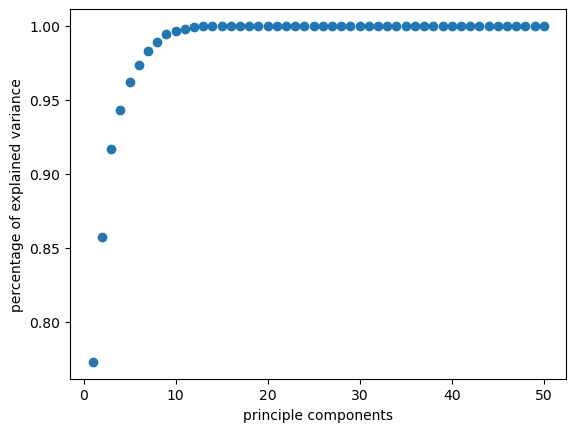

In [66]:
pca_show(example_data_unbalanced.drop(columns='Label'), num_components=50, verbose=True,plot=True,save_to_disk=False)

#### Test run of k-fold SVM classification on example data

In [15]:
df = example_data.sample(frac=1).reset_index(drop=True) # shuffle the df
# df_pre_alss = df.drop(columns=['Label'])
desired_percentage = 0.999
num_pc = pca_determine_num(df.drop(columns=['Label']), retain_percentage=desired_percentage)
print('Original: Number of PCs is: ', num_pc, f' which retains {desired_percentage} of variance')

Original: Number of PCs is:  12  which retains 0.999 of variance


In [16]:
df_unbalanced = example_data_unbalanced.sample(frac=1).reset_index(drop=True) # shuffle the df
# df_pre_alss = df.drop(columns=['Label'])
desired_percentage = 0.999
num_pc = pca_determine_num(df_unbalanced.drop(columns=['Label']), retain_percentage=desired_percentage)
print('Original: Number of PCs is: ', num_pc, f' which retains {desired_percentage} of variance')

Original: Number of PCs is:  12  which retains 0.999 of variance


In [17]:
def get_evaluatation(df, k_fold, svm_param, separate_pca = False, num_pc = num_pc, run_lda = False, verbose=1, plot=0):
    # Stratified K-Fold
    X = df.drop(columns=['Label'])
    y = df['Label']
    k = k_fold
    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        if num_pc!=0:
            if separate_pca:
                x_train_fold, x_test_fold = pca_separated(x_train_fold, x_test_fold, y_train_fold, num_pc, verbose=verbose, plot=0)
            else:
                x_train_fold, x_test_fold = pca(x_train_fold, x_test_fold, num_pc, verbose=verbose, plot=0)
            
            if verbose:
                print('Input dimension is:', x_train_fold.shape[1])
        
        if run_lda:
            lda = LDA()
            x_train_fold = lda.fit_transform(x_train_fold, y_train_fold)
            x_test_fold = lda.transform(x_test_fold)
            if verbose:
                print('Input dimension is:', x_train_fold.shape[1])
        
        if len(svm_param)==0:
            model = svm.SVC()
        else:
            model = svm.SVC(C=svm_param['C'], gamma=svm_param['gamma'], kernel=svm_param['kernel'])
        model.fit(x_train_fold, y_train_fold)
        accu_stratified.append(model.score(x_test_fold, y_test_fold))
    return np.mean(accu_stratified)

In [18]:
svm_param = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
get_evaluatation(df, k_fold=10, svm_param=svm_param, separate_pca = True, num_pc = num_pc, run_lda=True, verbose=0, plot=0)

0.8150000000000001

In [19]:
svm_param = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
get_evaluatation(df_unbalanced, k_fold=10, svm_param=svm_param, separate_pca = True, num_pc = num_pc, run_lda=True, verbose=0, plot=0)

0.8400000000000001

In [20]:
# df_unbalanced.to_csv('synth_data_'+ str(num_groups) + '_' + str(num_samples) +'_unbalanced.csv', index=False)

In [21]:
def generate_records(svm_param, separate_pca = False, num_pc = num_pc, run_lda = False):

    delt_means = np.arange(0, 0.35, 0.025)
    delt_sigs = np.arange(0, 0.35, 0.025)

    points = list(itertools.product(delt_means, delt_sigs))

    print('Number of points: ', len(points))

    mean_zero = 1
    sig_zero = 0.25
    
    records = []
    for point in tqdm(points, desc='Generating data for each configuration'):
        mean1,sig1 = mean_zero + point[0]/2, sig_zero + point[1]/2
        mean2,sig2 = mean_zero - point[0]/2, max(sig_zero - point[1]/2, 0)  # Ensure non-negative standard deviation
        df = generate_samples(all_groups[0:num_groups],mean1, sig1, mean2, sig2)
        df = df.sample(frac=1).reset_index(drop=True)
        score = get_evaluatation(df, k_fold=10, svm_param=svm_param, separate_pca = separate_pca, num_pc = num_pc, run_lda = run_lda, verbose=0, plot=0)
        records.append((round(mean1-mean2,2), round(sig1-sig2,2), score))

    return records

def generate_records_unbalanced(svm_param, separate_pca = False, num_pc = num_pc, run_lda = False):

    delt_means = np.arange(0, 0.35, 0.025)
    delt_sigs = np.arange(0, 0.35, 0.025)

    points = list(itertools.product(delt_means, delt_sigs))

    print('Number of points: ', len(points))

    mean_zero = 1
    sig_zero = 0.25
    
    records = []
    for point in tqdm(points, desc='Generating data for each configuration'):
        mean1,sig1 = mean_zero + point[0]/2, sig_zero + point[1]/2
        mean2,sig2 = mean_zero - point[0]/2, max(sig_zero - point[1]/2, 0)  # Ensure non-negative standard deviation
        df_unbalanced = generate_samples_unbalanced(all_groups[0:num_groups],mean1, sig1, mean2, sig2)
        df_unbalanced = df_unbalanced.sample(frac=1).reset_index(drop=True)
        score = get_evaluatation(df_unbalanced, k_fold=10, svm_param=svm_param, separate_pca = separate_pca, num_pc = num_pc, run_lda = run_lda, verbose=0, plot=0)
        records.append((round(mean1-mean2,2), round(sig1-sig2,2), score))

    return records

In [22]:
def genereate_contour(unbalanced = False, svm_param = [], seperate_pca = False, num_pc = num_pc, run_lda=False, num_tests=50, test_info = 'date_time', save_to_disk=False):
    all_records = []
    for i in range(num_tests):
        print('Test: ', i)
        if unbalanced:
            records = generate_records_unbalanced(svm_param, separate_pca=seperate_pca, num_pc=num_pc, run_lda=run_lda)
        else:
            records = generate_records(svm_param, separate_pca=seperate_pca, num_pc=num_pc, run_lda=run_lda)
        # records = pd.dataFrame(records, columns=['Mean Difference', 'Sigma Difference', 'Accuracy'])
        # records.to_csv('./Results/records_'+str(i)+'.csv', index=False)
        records = [list(t) for t in records]
        records = sorted(records, key=lambda x: x[0] + x[1])
        all_records.append(records)
    if save_to_disk:
        record_name = './records_'+ str(num_tests) + test_info +'.pkl'
        pickle.dump(all_records, open(record_name, 'wb'))
    return all_records

def retrive_contour(file_path):
    with open(file_path, 'rb') as f:
        all_records = pickle.load(f)
        return all_records

In [67]:
svm_param = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
records_0201 = genereate_contour(unbalanced= True, svm_param=svm_param, seperate_pca = False, num_pc = num_pc, run_lda=True, num_tests=20, test_info = '_0201_unbalanced_1pca', save_to_disk=True)

Test:  0
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [06:00<00:00,  1.84s/it]


Test:  1
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:43<00:00,  1.75s/it]


Test:  2
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:37<00:00,  1.72s/it]


Test:  3
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:57<00:00,  1.82s/it]


Test:  4
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [06:21<00:00,  1.94s/it]


Test:  5
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:41<00:00,  1.74s/it]


Test:  6
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:33<00:00,  1.70s/it]


Test:  7
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:41<00:00,  1.74s/it]


Test:  8
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:58<00:00,  1.83s/it]


Test:  9
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:37<00:00,  1.72s/it]


Test:  10
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:36<00:00,  1.72s/it]


Test:  11
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:18<00:00,  1.63s/it]


Test:  12
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:38<00:00,  1.73s/it]


Test:  13
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:56<00:00,  1.82s/it]


Test:  14
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:55<00:00,  1.82s/it]


Test:  15
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:58<00:00,  1.83s/it]


Test:  16
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:55<00:00,  1.81s/it]


Test:  17
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:52<00:00,  1.80s/it]


Test:  18
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:51<00:00,  1.79s/it]


Test:  19
Number of points:  196


Generating data for each configuration: 100%|██████████| 196/196 [05:26<00:00,  1.67s/it]


In [68]:
svm_param = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
records_0201 = genereate_contour(unbalanced= True, svm_param=svm_param, seperate_pca = True, num_pc = num_pc, run_lda=True, num_tests=20, test_info = '_0201_unbalanced_2pca', save_to_disk=True)

Test:  0
Number of points:  196


Generating data for each configuration:   0%|          | 0/196 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [24]:
record_1pca_no_lda = retrive_contour('./records_50_1pca_no_lda.pkl')
record_2pca_no_lda = retrive_contour('./records_50_2pca_no_lda.pkl')
record_1pca_with_lda = retrive_contour('./records_50_1pca_with_lda.pkl')
record_2pca_with_lda = retrive_contour('./records_50_2pca_with_lda.pkl')

In [49]:
record_2pca_with_lda_unbalanced = retrive_contour('./records_20_0131_unbalanced.pkl')
record_1pca_with_lda_unbalanced = retrive_contour('./records_20_0131_unbalanced_1pca.pkl')

In [34]:
# Retrive saved test data
def get_countour(all_records, num_tests, manual=False):
    record_df = []
    for records in all_records:
        y = [sublist[0] for sublist in records]  # First element from each sublist
        x = [sublist[1] for sublist in records]  # Second element from each sublist
        z = [sublist[2] for sublist in records] 

        x = np.array(list(x))
        y = np.array(list(y))
        z = np.array(list(z))
        record_df.append((x,y,z))

    df_sets = []
    for i in range(num_tests):
        df_sets.append({'x': record_df[i][0], 'y': record_df[i][1], 'z': record_df[i][2]})

    # Create a grid
    xi, yi = np.linspace(min(x for df in df_sets for x in df['x']), max(x for df in df_sets for x in df['x']), 100), np.linspace(min(y for df in df_sets for y in df['y']), max(y for df in df_sets for y in df['y']), 100)
    if manual:
        xi, yi = np.linspace(0, 0.35, 100), np.linspace(0, 0.35, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate each df set and average
    zi_sum = np.zeros_like(xi)
    for df in df_sets:
        zi = griddata((df['x'], df['y']), df['z'], (xi, yi), method='linear')
        zi_sum += np.nan_to_num(zi)  # Convert NaNs to zero for averaging

    zi_avg = zi_sum / len(df_sets)
    return xi, yi, zi_avg

def plot_contour(contour):
    plt.contourf(contour[0], contour[1], contour[2], levels=14, cmap="RdYlBu")
    # plt.clabel(contour_1pca, inline=True, fontsize=8)
    plt.colorbar()
    plt.xlabel('Difference in Standard Deviation', fontsize=10)
    plt.ylabel('Difference in Mean', fontsize=10)
    plt.show()

def plot_overlay_coutours(contour_1, contour_2, fill=False, cmap="RdYlBu"):
    # Plot
    if fill:
        contour_1pca = plt.contourf(contour_1[0], contour_1[1], contour_1[2], levels=14, cmap=cmap)
        countour_2pca = plt.contourf(contour_2[0], contour_2[1], contour_2[2], levels=14, cmap=cmap)
    else:
        contour_1pca = plt.contour(contour_1[0], contour_1[1], contour_1[2], levels=14, cmap="Reds")
        countour_2pca = plt.contour(contour_2[0], contour_2[1], contour_2[2], levels=14, cmap="Blues")
        
    # plt.clabel(contour_1pca, inline=True, fontsize=8)
    red_patch = mpatches.Patch(color='tab:red', label='1 PCA')
    # plt.clabel(countour_2pca, inline=True, fontsize=8)
    blue_patch = mpatches.Patch(color='tab:blue', label='2 PCA')

    plt.colorbar()
    plt.xlabel('Difference in Standard Deviation', fontsize=10)
    plt.ylabel('Difference in Mean', fontsize=10)
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

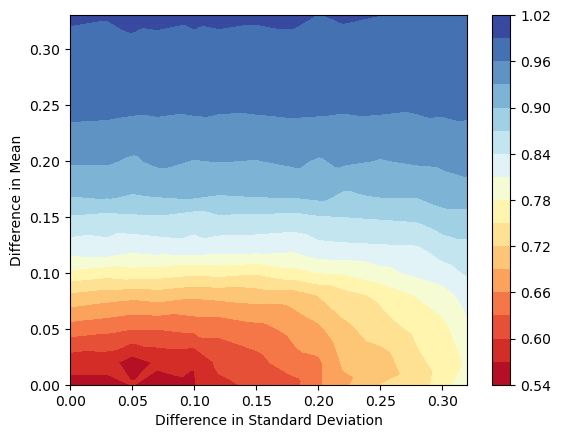

In [50]:
plot_contour(get_countour(record_1pca_with_lda_unbalanced, 20, manual=False))

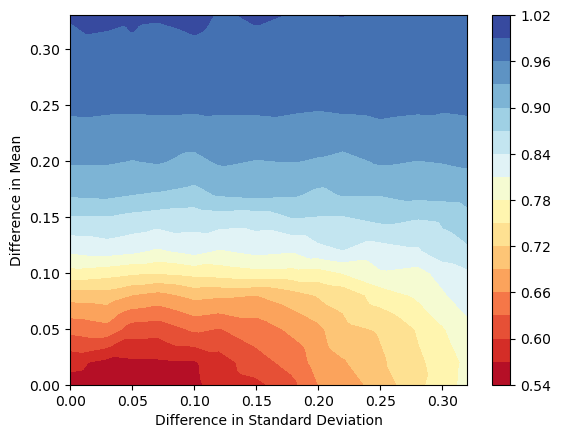

In [46]:
plot_contour(get_countour(record_2pca_with_lda_unbalanced, 20, manual=False))

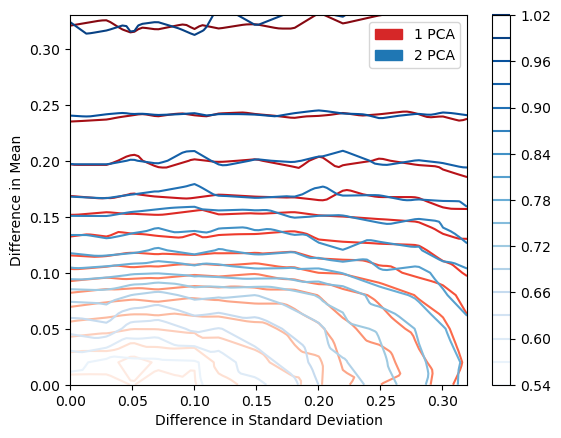

In [54]:
plot_overlay_coutours(get_countour(record_1pca_with_lda_unbalanced,20, manual=False), get_countour(record_2pca_with_lda_unbalanced,20, manual=False))

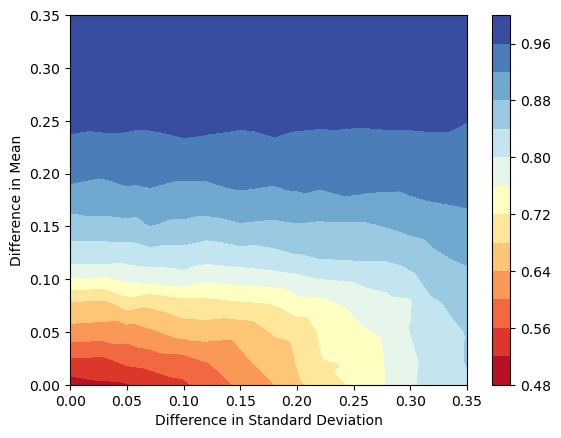

In [26]:
plot_contour(get_countour(record_1pca_with_lda, 20, manual=True))

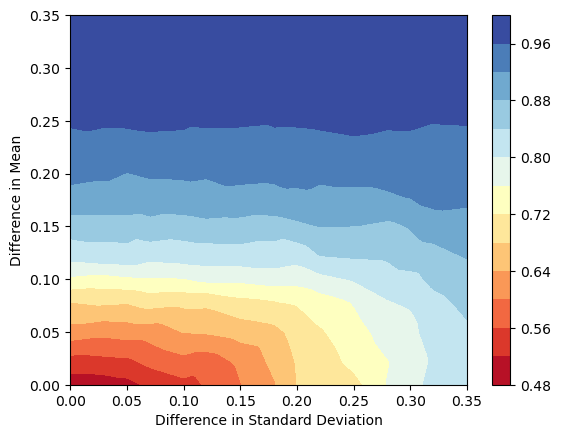

In [27]:
plot_contour(get_countour(record_2pca_with_lda, 20, manual=True))

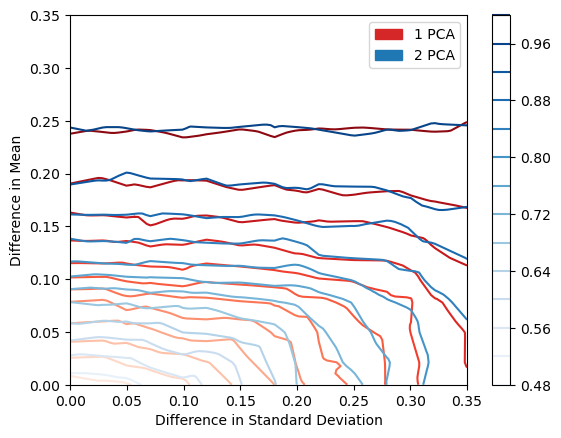

In [37]:
contour_1pca_with_lda = get_countour(record_1pca_with_lda, 20, manual=True)
contour_2pca_with_lda = get_countour(record_2pca_with_lda, 20, manual=True)

plot_overlay_coutours(contour_1pca_with_lda, contour_2pca_with_lda, fill=False)

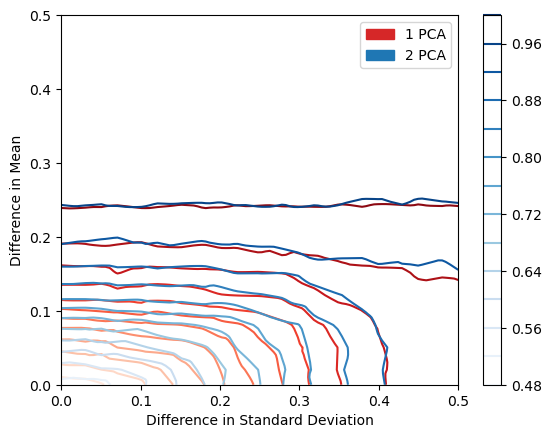

In [54]:
contour_1pca_with_lda = get_countour(record_1pca_with_lda, manual=False)
contour_2pca_with_lda = get_countour(record_2pca_with_lda, manual=False)

plot_overlay_coutours(contour_1pca_with_lda, contour_2pca_with_lda)